In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.linalg import norm
from scipy import spatial

In [2]:
# from gensim.test.utils import get_tmpfile, common_texts
# from gensim.models import Word2Vec

In [3]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [4]:
four_grams = [
    ['king', 'queen', 'man', 'woman'],
    ['King', 'Man', 'Queen', 'Woman'], # reordered + capitalization
    ['man', 'woman', 'boy', 'girl'],
    ['Ottawa', 'Canada', 'Nairobi', 'Kenya'],
    ['big', 'bigger', 'tall', 'taller'],
    ['yen', 'japan', 'ruble', 'russia'],
    ['man', 'doctor', 'woman', 'nurse'],  ## Bias in language  
    ['France', 'Paris', 'England', 'London'],
    ['healthy', 'salad', 'unhealthy', 'fries'],
    ['fruit', 'apple', 'vegetable', 'pumpkin'],
]

# 1. Using 10 (4-grams) of vectors (Paris, France:London, England), do the vector addition and subtraction and compare the vector to the last remaining vectors (aka Paris – France + England compared to London). Do this in GenSim. 

In [5]:
def compute_similarty(word1: np.array, word2: np.array, numpy=True, scipy=False):
    """
    Function computes the similarity between 2 word vectors.
    Computation is done using 2 methods: (1) using Scipy formula and (2) using Spacy/Gensim equivalent formula created with Numpy
    :param: word1: Word Vector for the 1st word
    :type: word1 np.array
    :param: word2: Word Vector for the 2nd word
    :type: word2 np.array
    :param numpy Whether to print the distance calculation using numpy (Default: True)
    :type numpy Bool
    :param scipy Whether to print the distance calculation using scipy (Default: False)
    :type numpy Bool
    """
    if scipy:
        # NOTE: that scipy uses distance, hence in order to calculate the similarity, we need to take 1 - distance
        cosine_distance_scipy = spatial.distance.cosine(word1, word2)  ## Scipy
        print(f"Cosine similarity using scipy (default: computes distance, i.e. less distance is more similar): {cosine_distance_scipy}")
        cosine_similarity_scipy = 1 - cosine_distance_scipy  ## Scipy
        print(f"Cosine Similarity using scipy (corected from distance to actual similarity): {cosine_similarity_scipy}")
    if numpy:
        cosine_similarity_numpy = np.dot(word1, word2)/(norm(word1)*norm(word2)) ## Manual
        print(f"Cosine Similarity using numpy (same formula as Gensim and SpaCy): {cosine_similarity_numpy}")  

### Observations
1. **For the most part, Gensim produces the expected analogy (there are some exceptions though, but this is expected since this method is only about 60% accurate).**
2. **Manual calculation of distance is also performed by adding and subtracting 3 of the 4 word vectors and comparing the result to the 4th word vector. The similarity is calculated using scipy (distance is converted to similarity by subtracting distance from 1) and also manually using numpy (recreating formula used in Gensim/SpaCy).** 
3. **When the most similar recommendation from Gensim matches with the 4th word in our four-gram, the similarity obtained from Gensim is very close to the manual calculation (though not exactly the same).** 

In [6]:
for index, four_gram in enumerate(four_grams):
    lhs = wv[four_gram[0]] - wv[four_gram[1]] + wv[four_gram[3]]
    rhs = wv[four_gram[2]]  
    print("\n", "-"*50, sep = "")
    print(f"Four-Gram {index+1}: Evaluating >>  '{four_gram[0]}'' : '{four_gram[1]}'' as ? : '{four_gram[3]}'\n")
    
    print("1.0 Using inbuilt functions to find most similar word ...")
    print(f"Positive: {four_gram[0]} {four_gram[3]} | Negative: {four_gram[1]} --> Expected: {four_gram[2]}")
    top_similar = wv.most_similar(positive=[four_gram[0], four_gram[3]], negative=[four_gram[1]], topn=5)
    print(f"Ans: '{top_similar[0][0]}' with a similarity of {top_similar[0][1]}")
    print(top_similar)
    
    print("\n2.0 Similarity using manual vector addition/subtraction ...")
    compute_similarty(lhs, rhs)



--------------------------------------------------
Four-Gram 1: Evaluating >>  'king'' : 'queen'' as ? : 'woman'

1.0 Using inbuilt functions to find most similar word ...
Positive: king woman | Negative: queen --> Expected: man
Ans: 'man' with a similarity of 0.72110915184021
[('man', 0.72110915184021), ('boy', 0.5595242977142334), ('teenage_girl', 0.513959527015686), ('girl', 0.49721550941467285), ('teenager', 0.4869248569011688)]

2.0 Similarity using manual vector addition/subtraction ...
Cosine Similarity using numpy (same formula as Gensim and SpaCy): 0.6913303732872009

--------------------------------------------------
Four-Gram 2: Evaluating >>  'King'' : 'Man'' as ? : 'Woman'

1.0 Using inbuilt functions to find most similar word ...
Positive: King Woman | Negative: Man --> Expected: Queen
Ans: 'Queen' with a similarity of 0.4929388165473938
[('Queen', 0.4929388165473938), ('Tupou_V.', 0.45174291729927063), ('Oprah_BFF_Gayle', 0.4422132670879364), ('Jackson', 0.4402504265308

# 2. Repeat the exercise in SpaCy.

### Observations:

1. **The similarities produced by Spacy are very high (> 0.6) in most cases, indicating that the algorithm is doing a good job at finding the missing word from the analogy.**

In [7]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [8]:
for index, four_gram in enumerate(four_grams):
    print("\n", "-"*50, sep = "")
    print(f"Four-Gram {index+1}: Evaluating >>  '{four_gram[0]}'' : '{four_gram[1]}'' as ? : '{four_gram[3]} --> Expected: {four_gram[2]}'")
    token1 = nlp(four_gram[0])
    token2 = nlp(four_gram[1])
    token3 = nlp(four_gram[2])
    token4 = nlp(four_gram[3])
    lhs = token1.vector - token2.vector + token4.vector
    rhs = token3.vector
    
    print("\n1.0 Similarity using manual vector addition/subtraction ...")
    compute_similarty(lhs, rhs)
    


--------------------------------------------------
Four-Gram 1: Evaluating >>  'king'' : 'queen'' as ? : 'woman --> Expected: man'

1.0 Similarity using manual vector addition/subtraction ...
Cosine Similarity using numpy (same formula as Gensim and SpaCy): 0.7820168137550354

--------------------------------------------------
Four-Gram 2: Evaluating >>  'King'' : 'Man'' as ? : 'Woman --> Expected: Queen'

1.0 Similarity using manual vector addition/subtraction ...
Cosine Similarity using numpy (same formula as Gensim and SpaCy): 0.7880844473838806

--------------------------------------------------
Four-Gram 3: Evaluating >>  'man'' : 'woman'' as ? : 'girl --> Expected: boy'

1.0 Similarity using manual vector addition/subtraction ...
Cosine Similarity using numpy (same formula as Gensim and SpaCy): 0.8328006863594055

--------------------------------------------------
Four-Gram 4: Evaluating >>  'Ottawa'' : 'Canada'' as ? : 'Kenya --> Expected: Nairobi'

1.0 Similarity using manual 

# 3. Compare the same vectors from Spacy and Gensim.  Can you mix the vectors from each group?

### Observations:

1. **We can see from the distributions below that the vectors from Gensim are very differnt than those from Spacy. This is due to the fact that when the original words are being projected onto the 300 dimensional embedding matrix, the dimensions between Gensim and Spacy will not align (i.e. dimention 1 in Gensim will not be the same as dimension 1 in Spacy, and so on). Moreover, both these use different algorithms to compute the embedding matrix. Hence we can not simply interchange these vectors.** 

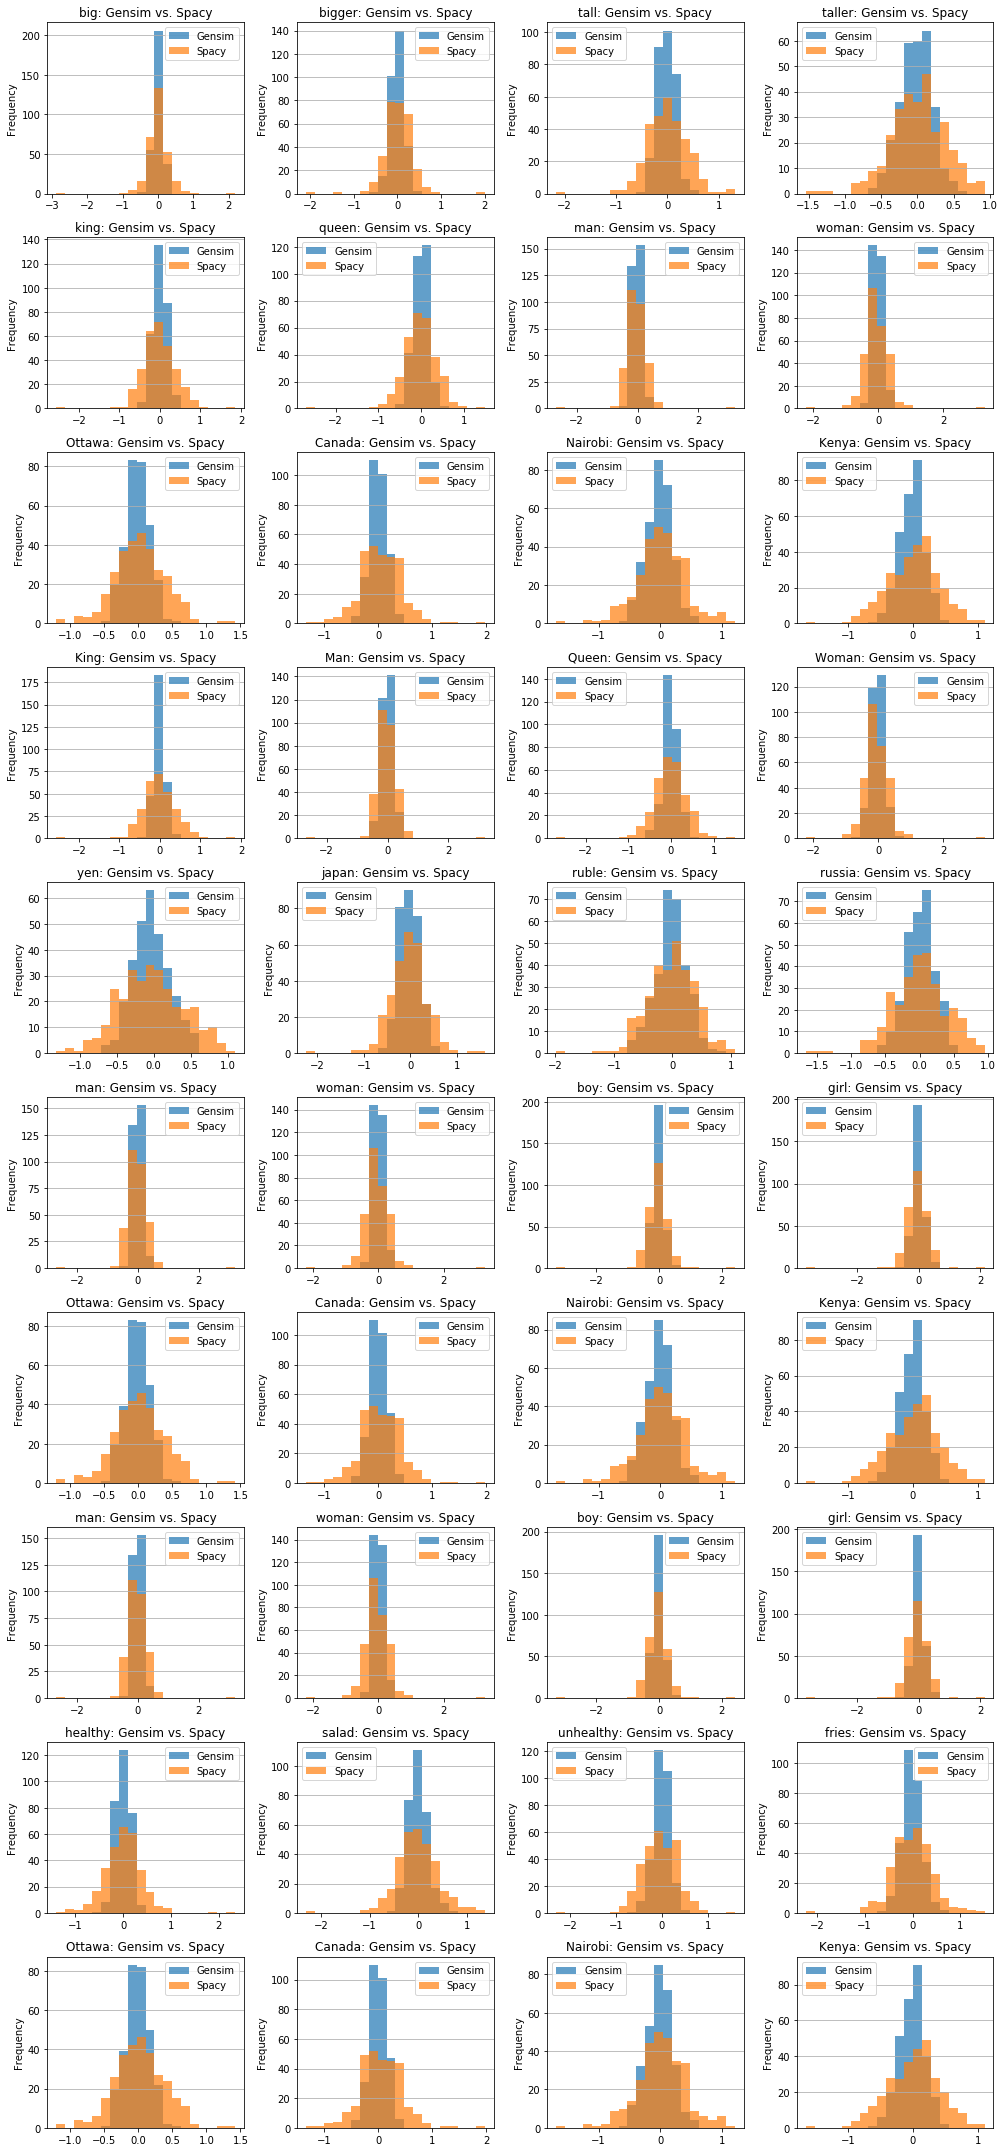

In [9]:
num_selected = 10
selected = np.random.randint(0, 10, num_selected)

fig, axes = plt.subplots(num_selected, 4, figsize=(14,num_selected*3))
for i, four_gram_index, in enumerate(selected):
    for word_index, word in enumerate(four_grams[four_gram_index]):
        gensim_vector = wv[word]
        spacy_vector = nlp(word).vector
        vectors = pd.DataFrame(np.vstack((gensim_vector, spacy_vector)).T, columns=['Gensim', 'Spacy'])
        vectors.plot.hist(bins=20, alpha = 0.7, ax=axes[i][word_index%4], title= word + ': Gensim vs. Spacy')
        axes[i][word_index%4].grid(axis='y')
        axes[i][word_index%4].legend(loc='best')
                   
plt.tight_layout()            
plt.show()

# 4. Using the [scipy distance formula](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html#scipy.spatial.distance.cosine), compare your results in SpaCy to this formula. What is the difference? What was changed?

**The difference between the scipy distance and the one used in SpaCy is that scipy computes the actual distance between the 2 vectors (link above in question), whereas SpaCy computes the angle between the vectors, i.e. cosine similarity. (I could not find the exact formula in the [documentation](https://spacy.io/api/doc#similarity) for this so had to look in the [source code](https://github.com/explosion/spaCy/blob/master/spacy/tokens/doc.pyx#L415)). This was briefly discussed above (as comments in the `compute_similarty` function), but in essesence, 2 'similar' words will produce a value close to 0 using the scipy formula "as is", whereas the same 2 words will produce a value close to 1 using the SpaCy formula.**

Scipy Distance Formula: $1 - \dfrac{u\cdot v}{||u||_2 ||v||_2}$

SpaCy Distance Formula: $\dfrac{u\cdot v}{||u||_2 ||v||_2}$

### Observations

* **As we can see from the analysis below, the results from Scipy are essentially equal to 1 - results from Spacy. After the adjustment for the '1' term, the results match up exactly.**

In [10]:
for index, four_gram in enumerate(four_grams):
    print("\n", "-"*50, sep = "")
    print(f"Four-Gram {index+1}: Evaluating >>  '{four_gram[0]}'' : '{four_gram[1]}'' as ? : '{four_gram[3]} --> Expected: {four_gram[2]}'")
    token1 = nlp(four_gram[0])
    token2 = nlp(four_gram[1])
    token3 = nlp(four_gram[2])
    token4 = nlp(four_gram[3])
    lhs = token1.vector - token2.vector + token4.vector
    rhs = token3.vector
    
    print("\n1.0 Similarity using manual vector addition/subtraction ...")
    compute_similarty(lhs, rhs, scipy=True)    


--------------------------------------------------
Four-Gram 1: Evaluating >>  'king'' : 'queen'' as ? : 'woman --> Expected: man'

1.0 Similarity using manual vector addition/subtraction ...
Cosine similarity using scipy (default: computes distance, i.e. less distance is more similar): 0.21798312664031982
Cosine Similarity using scipy (corected from distance to actual similarity): 0.7820168733596802
Cosine Similarity using numpy (same formula as Gensim and SpaCy): 0.7820168137550354

--------------------------------------------------
Four-Gram 2: Evaluating >>  'King'' : 'Man'' as ? : 'Woman --> Expected: Queen'

1.0 Similarity using manual vector addition/subtraction ...
Cosine similarity using scipy (default: computes distance, i.e. less distance is more similar): 0.21191561222076416
Cosine Similarity using scipy (corected from distance to actual similarity): 0.7880843877792358
Cosine Similarity using numpy (same formula as Gensim and SpaCy): 0.7880844473838806

-------------------

# 5. Manually verify the distance calculations (aka write your own formula) for Spacy Similarity and Scipy similarity. Did you match up the exact results?

Tne function below is essentially the same as the `compute_similarity` function that was defined above. The difference is that instead of using the `spatial.distance.cosine` function from `scipy`, we are calculating the same expression manually. `compute_similarity` was already computing the `SpaCy` similarity manually, so that has been left unchanged.

### Observations:

* **From the results below, we find that aftetr accounting the the '1' term in the scipy formula, the results match up exactly between `scipy` and `SpaCy`.**

In [11]:
def compute_similarty_full_manual(word1: np.array, word2: np.array, numpy=True, scipy=False):
    """
    Function manually computes the similarity between 2 word vectors.
    Computation is done using 2 methods: (1) using Scipy equivalent formula and (2) using Spacy/Gensim equivalent formula created with Numpy
    :param: word1: Word Vector for the 1st word
    :type: word1 np.array
    :param: word2: Word Vector for the 2nd word
    :type: word2 np.array
    :param numpy Whether to print the distance calculation using numpy (Default: True)
    :type numpy Bool
    :param scipy Whether to print the distance calculation using scipy (Default: False)
    :type numpy Bool
    """
    if scipy:
        # NOTE: that scipy uses distance, hence in order to calculate the similarity, we need to take 1 - distance
        cosine_distance_scipy = 1 - np.dot(word1, word2)/(norm(word1)*norm(word2))  ## Scipy equivalent (recreated manually)
        print(f"Cosine similarity using scipy (default: computes distance, i.e. less distance is more similar): {cosine_distance_scipy}")
        cosine_similarity_scipy = 1 - cosine_distance_scipy  ## Scipy equivalent (recreated manually)
        print(f"Cosine Similarity using scipy (corected from distance to actual similarity): {cosine_similarity_scipy}")
    if numpy:
        cosine_similarity_numpy = np.dot(word1, word2)/(norm(word1)*norm(word2)) ## Manual
        print(f"Cosine Similarity using numpy (same formula as Gensim and SpaCy): {cosine_similarity_numpy}")  

In [12]:
for index, four_gram in enumerate(four_grams):
    print("\n", "-"*50, sep = "")
    print(f"Four-Gram {index+1}: Evaluating >>  '{four_gram[0]}'' : '{four_gram[1]}'' as ? : '{four_gram[3]} --> Expected: {four_gram[2]}'")
    token1 = nlp(four_gram[0])
    token2 = nlp(four_gram[1])
    token3 = nlp(four_gram[2])
    token4 = nlp(four_gram[3])
    lhs = token1.vector - token2.vector + token4.vector
    rhs = token3.vector
    
    print("\n1.0 Similarity using manual vector addition/subtraction ...")
    compute_similarty_full_manual(lhs, rhs, scipy=True)    


--------------------------------------------------
Four-Gram 1: Evaluating >>  'king'' : 'queen'' as ? : 'woman --> Expected: man'

1.0 Similarity using manual vector addition/subtraction ...
Cosine similarity using scipy (default: computes distance, i.e. less distance is more similar): 0.2179831862449646
Cosine Similarity using scipy (corected from distance to actual similarity): 0.7820168137550354
Cosine Similarity using numpy (same formula as Gensim and SpaCy): 0.7820168137550354

--------------------------------------------------
Four-Gram 2: Evaluating >>  'King'' : 'Man'' as ? : 'Woman --> Expected: Queen'

1.0 Similarity using manual vector addition/subtraction ...
Cosine similarity using scipy (default: computes distance, i.e. less distance is more similar): 0.21191555261611938
Cosine Similarity using scipy (corected from distance to actual similarity): 0.7880844473838806
Cosine Similarity using numpy (same formula as Gensim and SpaCy): 0.7880844473838806

--------------------